In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3"

In [2]:
import torch
torch.cuda.set_device(2)
print(torch.cuda.is_available())
print(os.environ["CUDA_VISIBLE_DEVICES"])
print("Current device:", torch.cuda.current_device())
print("Device count:", torch.cuda.device_count())

True
0, 1, 2, 3
Current device: 2
Device count: 4


In [3]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
dir = '../cat_faces'
print(os.listdir(dir))

['cats']


In [5]:
# image_size = 64
image_size = 128
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(dir, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [7]:
def is_cuda_available():
    if torch.cuda.is_available():
        print("CUDA available. Training on GPU!")
        return torch.device('cuda')
    else:
        print("CUDA not available. Training on CPU!")
        return torch.device('cpu')
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device=is_cuda_available()
# device = torch.device("cuda")
train_dl = DeviceDataLoader(train_dl, device)

CUDA available. Training on GPU!


In [8]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8
    
    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

latent_size = 256
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    
    #NEEDED TO CHANGE
    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 4 x 4 ???????
    
    #NEEDED TO ADD
    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

In [9]:
sample_dir = 'generated4'
os.makedirs(sample_dir, exist_ok=True)
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

import numpy
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)
numpy.shape(fixed_latent)

torch.Size([128, 256, 1, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


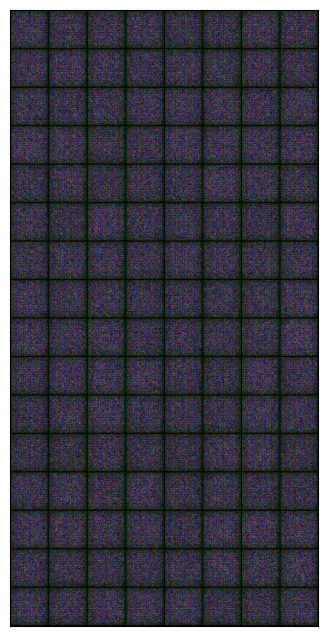

In [10]:
save_samples(0, fixed_latent)

In [11]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [12]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
#     opt_d = torch.optim.SGD(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
#     opt_g = torch.optim.SGD(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores


In [13]:
lr = 0.0003
epochs = 2500

In [ ]:
history=fit(epochs,lr)

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/2500], loss_g: 4.1388, loss_d: 5.0840, real_score: 0.0424, fake_score: 0.0060
Saving generated-images-0001.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/2500], loss_g: 5.1661, loss_d: 0.0384, real_score: 0.9972, fake_score: 0.0345
Saving generated-images-0002.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/2500], loss_g: 6.5266, loss_d: 0.0584, real_score: 0.9589, fake_score: 0.0160
Saving generated-images-0003.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/2500], loss_g: 8.6211, loss_d: 0.0021, real_score: 0.9995, fake_score: 0.0016
Saving generated-images-0004.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/2500], loss_g: 16.2588, loss_d: 0.0017, real_score: 0.9983, fake_score: 0.0000
Saving generated-images-0005.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/2500], loss_g: 1.7271, loss_d: 0.3520, real_score: 0.7219, fake_score: 0.0000
Saving generated-images-0006.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/2500], loss_g: 11.7650, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-0007.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/2500], loss_g: 6.7854, loss_d: 0.0036, real_score: 0.9978, fake_score: 0.0014
Saving generated-images-0008.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/2500], loss_g: 8.2553, loss_d: 0.0009, real_score: 0.9994, fake_score: 0.0003
Saving generated-images-0009.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/2500], loss_g: 0.0000, loss_d: 1.5350, real_score: 0.4788, fake_score: 0.0000
Saving generated-images-0010.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/2500], loss_g: 5.1426, loss_d: 0.6748, real_score: 0.8687, fake_score: 0.2994
Saving generated-images-0011.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/2500], loss_g: 3.8575, loss_d: 0.2847, real_score: 0.9578, fake_score: 0.2022
Saving generated-images-0012.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/2500], loss_g: 4.9189, loss_d: 0.0304, real_score: 0.9916, fake_score: 0.0214
Saving generated-images-0013.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/2500], loss_g: 3.5553, loss_d: 0.3697, real_score: 0.9472, fake_score: 0.2447
Saving generated-images-0014.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/2500], loss_g: 1.5875, loss_d: 1.6383, real_score: 0.4713, fake_score: 0.3853
Saving generated-images-0015.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/2500], loss_g: 7.7484, loss_d: 0.4234, real_score: 0.9867, fake_score: 0.3103
Saving generated-images-0016.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/2500], loss_g: 9.8038, loss_d: 1.9603, real_score: 0.9814, fake_score: 0.8123
Saving generated-images-0017.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/2500], loss_g: 5.3513, loss_d: 1.6954, real_score: 0.9302, fake_score: 0.7572
Saving generated-images-0018.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/2500], loss_g: 2.2876, loss_d: 0.5788, real_score: 0.7526, fake_score: 0.2144
Saving generated-images-0019.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/2500], loss_g: 4.4554, loss_d: 0.1073, real_score: 0.9509, fake_score: 0.0525
Saving generated-images-0020.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/2500], loss_g: 7.6834, loss_d: 0.0032, real_score: 0.9985, fake_score: 0.0017
Saving generated-images-0021.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/2500], loss_g: 0.0396, loss_d: 6.4072, real_score: 0.0038, fake_score: 0.0008
Saving generated-images-0022.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/2500], loss_g: 38.6332, loss_d: 0.0010, real_score: 0.9990, fake_score: 0.0000
Saving generated-images-0023.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/2500], loss_g: 38.6037, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0024.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/2500], loss_g: 38.5723, loss_d: 0.0050, real_score: 0.9950, fake_score: 0.0000
Saving generated-images-0025.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/2500], loss_g: 38.5619, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0026.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/2500], loss_g: 38.5236, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0027.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/2500], loss_g: 38.5190, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0028.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/2500], loss_g: 38.5194, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0029.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/2500], loss_g: 38.4917, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0030.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/2500], loss_g: 38.4608, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0031.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/2500], loss_g: 38.4634, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0032.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/2500], loss_g: 38.4457, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0033.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/2500], loss_g: 38.4103, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0034.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/2500], loss_g: 38.3915, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0035.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/2500], loss_g: 38.3505, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-0036.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/2500], loss_g: 38.3316, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0037.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/2500], loss_g: 38.3072, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0038.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/2500], loss_g: 38.2767, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0039.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/2500], loss_g: 38.2271, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0040.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [41/2500], loss_g: 34.4235, loss_d: 1.0965, real_score: 0.6779, fake_score: 0.0000
Saving generated-images-0041.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [42/2500], loss_g: 2.1037, loss_d: 1.2784, real_score: 0.5143, fake_score: 0.1454
Saving generated-images-0042.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [43/2500], loss_g: 5.0183, loss_d: 0.4569, real_score: 0.9308, fake_score: 0.2988
Saving generated-images-0043.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [44/2500], loss_g: 0.6306, loss_d: 0.6992, real_score: 0.5962, fake_score: 0.1295
Saving generated-images-0044.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [45/2500], loss_g: 0.4828, loss_d: 2.0833, real_score: 0.1760, fake_score: 0.2199
Saving generated-images-0045.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [46/2500], loss_g: 5.2897, loss_d: 0.6584, real_score: 0.9967, fake_score: 0.4491
Saving generated-images-0046.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [47/2500], loss_g: 2.7369, loss_d: 0.4071, real_score: 0.9110, fake_score: 0.2563
Saving generated-images-0047.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [48/2500], loss_g: 4.0937, loss_d: 0.1836, real_score: 0.9139, fake_score: 0.0818
Saving generated-images-0048.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [49/2500], loss_g: 2.4634, loss_d: 0.5577, real_score: 0.6985, fake_score: 0.1696
Saving generated-images-0049.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [50/2500], loss_g: 0.8137, loss_d: 1.6547, real_score: 0.2885, fake_score: 0.0427
Saving generated-images-0050.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [51/2500], loss_g: 4.2277, loss_d: 3.5796, real_score: 0.0639, fake_score: 0.0021
Saving generated-images-0051.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [52/2500], loss_g: 3.7969, loss_d: 0.0755, real_score: 0.9965, fake_score: 0.0687
Saving generated-images-0052.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [53/2500], loss_g: 6.9054, loss_d: 0.0079, real_score: 0.9939, fake_score: 0.0018
Saving generated-images-0053.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [54/2500], loss_g: 5.6673, loss_d: 0.0047, real_score: 0.9997, fake_score: 0.0044
Saving generated-images-0054.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [55/2500], loss_g: 6.0539, loss_d: 0.0061, real_score: 0.9994, fake_score: 0.0055
Saving generated-images-0055.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [56/2500], loss_g: 8.3331, loss_d: 0.0219, real_score: 0.9785, fake_score: 0.0001
Saving generated-images-0056.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [57/2500], loss_g: 6.3156, loss_d: 0.0056, real_score: 0.9975, fake_score: 0.0031
Saving generated-images-0057.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [58/2500], loss_g: 8.6251, loss_d: 0.0051, real_score: 0.9957, fake_score: 0.0007
Saving generated-images-0058.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [59/2500], loss_g: 6.9249, loss_d: 0.0716, real_score: 0.9331, fake_score: 0.0007
Saving generated-images-0059.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [60/2500], loss_g: 9.5407, loss_d: 0.0390, real_score: 0.9623, fake_score: 0.0000
Saving generated-images-0060.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [61/2500], loss_g: 2.6808, loss_d: 1.5401, real_score: 0.5905, fake_score: 0.1570
Saving generated-images-0061.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [62/2500], loss_g: 1.6103, loss_d: 1.6925, real_score: 0.4165, fake_score: 0.2833
Saving generated-images-0062.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [63/2500], loss_g: 4.1808, loss_d: 0.8883, real_score: 0.8399, fake_score: 0.4623
Saving generated-images-0063.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [64/2500], loss_g: 6.6163, loss_d: 0.6113, real_score: 0.9493, fake_score: 0.3878
Saving generated-images-0064.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [65/2500], loss_g: 4.6232, loss_d: 0.4011, real_score: 0.7314, fake_score: 0.0556
Saving generated-images-0065.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [66/2500], loss_g: 1.5527, loss_d: 1.2876, real_score: 0.3367, fake_score: 0.1251
Saving generated-images-0066.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [67/2500], loss_g: 2.6166, loss_d: 1.1570, real_score: 0.6171, fake_score: 0.2910
Saving generated-images-0067.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [68/2500], loss_g: 3.9377, loss_d: 0.7195, real_score: 0.9948, fake_score: 0.4401
Saving generated-images-0068.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [69/2500], loss_g: 3.9250, loss_d: 0.1277, real_score: 0.9089, fake_score: 0.0263
Saving generated-images-0069.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [70/2500], loss_g: 5.8750, loss_d: 1.3527, real_score: 0.9985, fake_score: 0.7085
Saving generated-images-0070.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [71/2500], loss_g: 2.1768, loss_d: 0.2912, real_score: 0.8420, fake_score: 0.1018
Saving generated-images-0071.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [72/2500], loss_g: 5.7694, loss_d: 0.0618, real_score: 0.9571, fake_score: 0.0170
Saving generated-images-0072.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [73/2500], loss_g: 3.7933, loss_d: 0.1851, real_score: 0.9695, fake_score: 0.1368
Saving generated-images-0073.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [74/2500], loss_g: 3.7442, loss_d: 0.4243, real_score: 0.6968, fake_score: 0.0224
Saving generated-images-0074.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [75/2500], loss_g: 6.0677, loss_d: 1.0206, real_score: 0.8725, fake_score: 0.5331
Saving generated-images-0075.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [76/2500], loss_g: 5.6832, loss_d: 1.9019, real_score: 0.9761, fake_score: 0.7855
Saving generated-images-0076.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [77/2500], loss_g: 1.4303, loss_d: 1.0808, real_score: 0.3953, fake_score: 0.0036
Saving generated-images-0077.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [78/2500], loss_g: 3.4066, loss_d: 0.0679, real_score: 0.9743, fake_score: 0.0398
Saving generated-images-0078.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [79/2500], loss_g: 3.1558, loss_d: 0.1541, real_score: 0.8854, fake_score: 0.0256
Saving generated-images-0079.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [80/2500], loss_g: 4.9082, loss_d: 2.0583, real_score: 0.1503, fake_score: 0.0039
Saving generated-images-0080.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [81/2500], loss_g: 7.4361, loss_d: 0.0093, real_score: 0.9925, fake_score: 0.0017
Saving generated-images-0081.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [82/2500], loss_g: 9.7430, loss_d: 0.0020, real_score: 0.9981, fake_score: 0.0001
Saving generated-images-0082.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [83/2500], loss_g: 3.9789, loss_d: 0.0128, real_score: 0.9971, fake_score: 0.0098
Saving generated-images-0083.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [84/2500], loss_g: 4.0162, loss_d: 0.6398, real_score: 0.8539, fake_score: 0.3507
Saving generated-images-0084.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [85/2500], loss_g: 3.9097, loss_d: 1.5469, real_score: 0.4391, fake_score: 0.0061
Saving generated-images-0085.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [86/2500], loss_g: 3.5178, loss_d: 0.1582, real_score: 0.9715, fake_score: 0.1167
Saving generated-images-0086.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [87/2500], loss_g: 2.5879, loss_d: 0.1076, real_score: 0.9633, fake_score: 0.0667
Saving generated-images-0087.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [88/2500], loss_g: 3.6962, loss_d: 1.1023, real_score: 0.3786, fake_score: 0.0027
Saving generated-images-0088.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [89/2500], loss_g: 11.1541, loss_d: 0.0030, real_score: 0.9971, fake_score: 0.0000
Saving generated-images-0089.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [90/2500], loss_g: 8.4006, loss_d: 0.5832, real_score: 0.9995, fake_score: 0.4180
Saving generated-images-0090.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [91/2500], loss_g: 7.7680, loss_d: 0.0048, real_score: 0.9957, fake_score: 0.0005
Saving generated-images-0091.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [92/2500], loss_g: 3.7154, loss_d: 2.5834, real_score: 0.0788, fake_score: 0.0155
Saving generated-images-0092.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [93/2500], loss_g: 5.4596, loss_d: 0.1994, real_score: 0.8464, fake_score: 0.0074
Saving generated-images-0093.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [94/2500], loss_g: 7.1678, loss_d: 0.0027, real_score: 0.9993, fake_score: 0.0021
Saving generated-images-0094.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [95/2500], loss_g: 9.0209, loss_d: 0.0055, real_score: 0.9948, fake_score: 0.0004
Saving generated-images-0095.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [96/2500], loss_g: 1.4104, loss_d: 3.8276, real_score: 0.0506, fake_score: 0.0019
Saving generated-images-0096.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [97/2500], loss_g: 6.6709, loss_d: 0.5828, real_score: 0.9728, fake_score: 0.3562
Saving generated-images-0097.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [98/2500], loss_g: 1.6822, loss_d: 0.5024, real_score: 0.7371, fake_score: 0.0843
Saving generated-images-0098.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [99/2500], loss_g: 6.6559, loss_d: 5.5685, real_score: 0.0114, fake_score: 0.0002
Saving generated-images-0099.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [100/2500], loss_g: 7.3180, loss_d: 0.1481, real_score: 0.8649, fake_score: 0.0008
Saving generated-images-0100.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [101/2500], loss_g: 4.0011, loss_d: 0.1613, real_score: 0.8764, fake_score: 0.0098
Saving generated-images-0101.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [102/2500], loss_g: 3.0887, loss_d: 0.1758, real_score: 0.8965, fake_score: 0.0596
Saving generated-images-0102.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [103/2500], loss_g: 4.4043, loss_d: 0.2827, real_score: 0.9852, fake_score: 0.2240
Saving generated-images-0103.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [104/2500], loss_g: 1.0623, loss_d: 1.3284, real_score: 0.3189, fake_score: 0.0882
Saving generated-images-0104.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [105/2500], loss_g: 6.3432, loss_d: 3.0439, real_score: 0.0612, fake_score: 0.0012
Saving generated-images-0105.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [106/2500], loss_g: 4.9983, loss_d: 1.2164, real_score: 0.4414, fake_score: 0.0018
Saving generated-images-0106.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [107/2500], loss_g: 9.8123, loss_d: 0.0039, real_score: 0.9964, fake_score: 0.0003
Saving generated-images-0107.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [108/2500], loss_g: 9.6044, loss_d: 0.3305, real_score: 0.7355, fake_score: 0.0001
Saving generated-images-0108.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [109/2500], loss_g: 4.2430, loss_d: 0.0298, real_score: 0.9864, fake_score: 0.0158
Saving generated-images-0109.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [110/2500], loss_g: 2.9310, loss_d: 1.4332, real_score: 0.4176, fake_score: 0.0761
Saving generated-images-0110.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [111/2500], loss_g: 4.6872, loss_d: 2.5848, real_score: 0.1095, fake_score: 0.0004
Saving generated-images-0111.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [112/2500], loss_g: 3.9842, loss_d: 0.5127, real_score: 0.6270, fake_score: 0.0033
Saving generated-images-0112.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [113/2500], loss_g: 4.4641, loss_d: 0.1824, real_score: 0.8677, fake_score: 0.0325
Saving generated-images-0113.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [114/2500], loss_g: 8.7071, loss_d: 0.0680, real_score: 0.9364, fake_score: 0.0002
Saving generated-images-0114.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [115/2500], loss_g: 2.2853, loss_d: 2.8009, real_score: 0.0657, fake_score: 0.0204
Saving generated-images-0115.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [116/2500], loss_g: 8.4445, loss_d: 0.1301, real_score: 0.8784, fake_score: 0.0002
Saving generated-images-0116.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [117/2500], loss_g: 8.2953, loss_d: 0.0250, real_score: 0.9756, fake_score: 0.0002
Saving generated-images-0117.png


  0%|          | 0/124 [00:00<?, ?it/s]

In [ ]:
from IPython.display import Image
Image('./generated2/generated-images-0280.png')